In [1]:
import numpy as np
import pandas as pd
import utm
import math
import pickle
import os
import sys
import time
import datetime
from collections import defaultdict
import matplotlib
import matplotlib.pyplot as plt
from pymongo.mongo_client import MongoClient
from shapely.geometry import Point, LineString
import copy

In [2]:
dataset = 'siping'
datatype = '2g'
data_file = './data/%s_%s/data_%s.csv' % (dataset, datatype, datatype)
gongcan_file = './data/%s_%s/gongcan_%s.csv' % (dataset, datatype, datatype)
disp_path = './display/%s_%s/' % (dataset, datatype)
data_path = './data/%s_%s/' % (dataset, datatype)
map_file = './data/%s_map/%s_EdgeGeometry.txt' % (dataset, dataset)
data_folder = data_path + 'result/'
with open(data_folder + 'ID1.pkl') as fin:
    id1, id1d = pickle.load(fin)
with open(data_folder + 'ID1ID2.pkl') as fin:
    id1id2, id1id2d = pickle.load(fin)
# with open(data_folder + 'ID1_rssi.pkl') as fin:
#     id1rssi, id1drssi = pickle.load(fin)
# with open(data_folder + 'ID1ID2_rssi.pkl') as fin:
#     id1id2rssi, id1id2drssi = pickle.load(fin)

In [3]:
print 'ID1                    ', np.median(id1), np.median(id1d.values()), np.mean(id1), len(id1d)
print 'ID1ID2                 ', np.median(id1id2), np.median(id1id2d.values()), np.mean(id1id2), len(id1id2d)
print 'ID1_rssi               ', np.median(id1rssi), np.median(id1drssi.values()), np.mean(id1rssi), len(id1drssi)
print 'ID1ID2_rssi            ', np.median(id1id2rssi), np.median(id1id2drssi.values()), np.mean(id1id2rssi), len(id1id2drssi)

ID1                     30.519828099959355 42.41239691247122 62.6693820358445 18
ID1ID2                  19.312699697954272 30.567855539590788 41.3435230891189 18
ID1_rssi               

NameError: name 'id1rssi' is not defined

In [2]:
data_folder = './data/jiading/result/'
with open(data_folder + 'ID1ID2_side=15.pkl') as fin:
    s1, s1d = pickle.load(fin)
with open(data_folder + 'ID1ID2_side=20.pkl') as fin:
    s2, s2d = pickle.load(fin)
with open(data_folder + 'ID1ID2_side=30.pkl') as fin:
    s3, s3d = pickle.load(fin)

In [6]:
print 'ID1ID2_side=15', np.median(s1), np.median(s1d.values()), np.mean(s1), len(s1d)
print 'ID1ID2_side=20', np.median(s2), np.median(s2d.values()), np.mean(s2), len(s2d)
print 'ID1ID2_side=30', np.median(s3), np.median(s3d.values()), np.mean(s3), len(s3d)

ID1ID2_side=15 33.11471412538552 59.126511493702886 65.2654948700098 47
ID1ID2_side=20 33.39353563190869 54.14392560629506 64.96381576508581 49
ID1ID2_side=30 38.49172838850944 59.49653105095306 68.98515250963467 57


In [4]:
def CDF(results, legend, title, fname):
    for result in results:
        count = len(result)
        X = sorted(result)
        Y = np.cumsum([1.0/count] * count)
        plt.plot(X, Y)
    plt.legend(legend)
    plt.title(title)
    plt.savefig(data_folder + fname)
    plt.close()
CDF([id1, id1id2, id1rssi, id1id2rssi], ['(ID1)', '(ID1,ID2)', '(ID1,rssi1)', '(ID1,rssi1,ID2,rssi2)'], 'Localization using different features', 'exp.png')
# CDF([s1, s2, s3], ['side=15', 'side=20', 'side=30'], 'Feature:(ID1ID2) Diff cell width', 'side.png')

# Mongo Display

In [23]:
mongo = MongoClient(host='10.60.43.110', port=27017)
bsloc = mongo['SeqIDLoc']

# Cell Width

In [19]:
widths = list(bsloc['runs'].find({'status':'COMPLETED', 'config.dataset':'siping', 'config.datatype':'4g', 'config.neighbor':True, 'config.with_rssi':0}))
pd_width = pd.DataFrame(c['config'] for c in widths)[['side']]
pd_width['mean'] = [r['info']['layer2'][2] for r in widths]
pd_width['median'] = [r['info']['layer2'][1] for r in widths]
p67 = []
for r in widths:
    errors = sorted(r['info']['layer2'][0])
    err_loc = errors[int(len(errors) * 0.67)]
    p67.append(err_loc)
pd_width['67%'] = p67
pd_width['time'] = [r['info']['total_time'] for r in widths]
pd_width['id'] = [r['_id'] for r in widths]
pd_width = pd_width.sort_values(by=['side']).reset_index(drop=True)

In [21]:
pd_width[['side', 'mean', 'median', '67%']]
# pd_width

,side,mean,median,67%
0,15,34.841270,4.765727,9.686102
1,20,6.399540,2.555291,4.864400
2,30,15.432231,5.206708,11.221381
3,50,6.562462,3.233878,6.114829
4,100,26.575276,8.264615,20.517239


# Missing RSSI

In [69]:
rssis = list(bsloc['runs'].find({'status':'COMPLETED','config.dataset':'jiading', 'config.datatype':'2g', 'config.neighbor':True, 'config.with_rssi':{'$ne':0}}))
pd_rssi = pd.DataFrame(c['config'] for c in rssis)[['with_rssi']]
pd_rssi['mean'] = [r['info']['layer2'][2] for r in rssis]
pd_rssi['median'] = [r['info']['layer2'][1] for r in rssis]
p67 = []
for r in rssis:
    errors = sorted(r['info']['layer2'][0])
    err_loc = errors[int(len(errors) * 0.67)]
    p67.append(err_loc)
pd_rssi['67%'] = p67
pd_rssi['time'] = [r['info']['total_time'] for r in rssis]
pd_rssi['id'] = [r['_id'] for r in rssis]
pd_rssi = pd_rssi.sort_values(by=['with_rssi']).reset_index(drop=True)

In [70]:
pd_rssi[['with_rssi', 'mean', 'median', '67%']]
# pd_rssi

,with_rssi,mean,median,67%
0,0.2,65.553897,31.421233,59.654371
1,0.4,60.074535,30.220265,54.386886
2,0.6,47.195519,24.793666,43.742942
3,0.8,46.465789,22.399516,40.596740
4,1.0,33.152413,15.040264,29.152378


# Number of BS IDs

In [80]:
neighbors = list(bsloc['runs'].find({'status':'COMPLETED', 'config.dataset':'siping', 'config.datatype':'2g', 'config.neighbor':{'$in': [1, 2, 3]}, 'config.side':30, 'config.with_rssi':0}))
pd_neigh = pd.DataFrame(c['config'] for c in neighbors)[['neighbor']]
pd_neigh['mean'] = [r['info']['layer2'][2] for r in neighbors]
pd_neigh['median'] = [r['info']['layer2'][1] for r in neighbors]
p67 = []
for r in neighbors:
    errors = sorted(r['info']['layer2'][0])
    err_loc = errors[int(len(errors) * 0.67)]
    p67.append(err_loc)
pd_neigh['67%'] = p67
pd_neigh['time'] = [r['info']['total_time'] for r in neighbors]
pd_neigh['id'] = [r['_id'] for r in neighbors]
pd_neigh = pd_neigh.sort_values(by=['neighbor']).reset_index(drop=True)

In [81]:
pd_neigh[['neighbor', 'mean', 'median', '67%']]

,neighbor,mean,median,67%
0,1,32.671394,18.276059,33.490196
1,2,27.091289,13.202274,22.602402
2,3,15.485514,9.646537,17.465648


# RSSI-based

In [194]:
mongo = MongoClient(host='localhost', port=27017)
bsloc = mongo['SeqIDLoc']
res_bs = list(bsloc['runs'].find({'status':'COMPLETED', 'config.side': 30, 'config.with_rssi':0}))
pd_bs = pd.DataFrame(c['config'] for c in res_bs)[['dataset', 'datatype', 'neighbor']]
pd_bs['median'] = [r['info']['layer2'][1] for r in res_bs]
pd_bs['errors'] = [r['info']['layer2'][0] for r in res_bs]
pd_bs['id'] = [r['_id'] for r in res_bs]
pd_bs = pd_bs.sort_values(by=['dataset', 'datatype', 'neighbor']).reset_index(drop=True)

In [195]:
pd_bs

,dataset,datatype,neighbor,median,errors,id
0,jiading,2g,False,50.288578,"[282.890969629, 282.554044581, 282.463371822, ...",10
1,jiading,2g,True,25.996373,"[6.67591936213, 21.7961795724, 110.437145331, ...",2
2,jiading,4g,False,16.277677,"[115.212832857, 173.742118222, 89.3706730374, ...",9
3,jiading,4g,True,17.226973,"[55.0131255655, 45.3116442192, 172.215868378, ...",13
4,siping,2g,False,16.360526,"[6.88522187362, 1.226074122, 6.37902772034, 3....",11
5,siping,2g,True,13.095984,"[2.5309424529, 4.51872590894, 20.6667639448, 4...",14
6,siping,4g,False,5.172082,"[4.6928516521e-09, 4.6928516521e-09, 0.1311425...",12
7,siping,4g,True,5.206708,"[4.6928516521e-09, 4.6928516521e-09, 0.2160099...",15


In [198]:
mongo = MongoClient(host='localhost', port=27017)
csloc = mongo['CellSense']
res_cs = list(csloc['runs'].find({'status':'COMPLETED'}))
pd_cs = pd.DataFrame(c['config'] for c in res_cs)[['dataset', 'datatype']]
pd_cs['median'] = [r['info']['result'][1] for r in res_cs]
pd_cs['errors'] = [r['info']['result'][0] for r in res_cs]
pd_cs['id'] = [r['_id'] for r in res_cs]
pd_cs = pd_cs.sort_values(by=['dataset', 'datatype']).reset_index(drop=True)

In [199]:
pd_cs

,dataset,datatype,median,errors,id
0,jiading,2g,17.0,"[0.0, 180.2, 21.1, 2.3, 334.4, 2.5, 8.5, 66.8,...",1
1,jiading,4g,27.8,"[44.2, 24.7, 18.9, 275.7, 13.5, 4.1, 3.9, 3.7,...",8
2,siping,2g,9.4,"[1.9, 27.1, 18.8, 9.7, 8.9, 9.5, 14.9, 39.0, 1...",5
3,siping,4g,9.9,"[7.2, 117.9, 2.8, 32.3, 59.4, 13.3, 2.4, 30.3,...",6


In [200]:
mongo = MongoClient(host='localhost', port=27017)
rfloc = mongo['ContextRF']
res_rf = list(rfloc['runs'].find({'status':'COMPLETED'}))
pd_rf = pd.DataFrame(c['config'] for c in res_rf)[['dataset', 'datatype']]
pd_rf['median'] = [r['info']['result'][1] for r in res_rf]
pd_rf['errors'] = [r['info']['result'][0] for r in res_rf]
pd_rf['id'] = [r['_id'] for r in res_rf]
pd_rf = pd_rf.sort_values(by=['dataset', 'datatype']).reset_index(drop=True)

In [201]:
pd_rf

,dataset,datatype,median,errors,id
0,jiading,2g,20.3,"[11.4, 7.3, 4.1, 48.9, 62.3, 39.3, 82.8, 30.4,...",1
1,jiading,4g,20.3,"[438.8, 479.0, 105.3, 82.4, 42.1, 33.5, 219.3,...",2
2,siping,2g,6.5,"[140.7, 36.2, 33.0, 48.2, 56.5, 17.0, 5.1, 7.6...",7
3,siping,4g,11.8,"[80.3, 13.4, 13.6, 11.4, 11.3, 10.5, 11.0, 11....",8


In [202]:
def make_XY(precision, n_count):
    count = len(precision)
    step = int(count / n_count)
    X = [precision[i] for i in range(step-1,count,step)]
    Y = list(np.cumsum([1.0/n_count] * n_count))
    X.insert(0, 0)
    Y.insert(0, 0)
    return X, Y
def plot(dataset, datatype, xlim, ylim, title, n_count=10):
    cellsense = sorted(pd_cs[(pd_cs['dataset']==dataset) & (pd_cs['datatype']==datatype)]['errors'].values[0])
    contextrf = sorted(pd_rf[(pd_rf['dataset']==dataset) & (pd_rf['datatype']==datatype)]['errors'].values[0])
    bsloc1 = sorted(pd_bs[(pd_bs['dataset']==dataset) & (pd_bs['datatype']==datatype) & (pd_bs['neighbor']==False)]['errors'].values[0])
    bsloc2 = sorted(pd_bs[(pd_bs['dataset']==dataset) & (pd_bs['datatype']==datatype) & (pd_bs['neighbor']==True)]['errors'].values[0])
    for data, linesty in [(contextrf, 'b--+'), (cellsense, 'r--s'), (bsloc2,'k-o')]:
#         print linesty
        X, Y = make_XY(data, n_count)
        plt.plot(X, Y, linesty)
    plt.legend(['CCR', 'CellSense', 'BSLoc'], loc='best')
    plt.xlim(xlim[0], xlim[1])
    plt.ylim(ylim[0], ylim[1])
    plt.yticks(np.arange(ylim[0], ylim[1] + 0.1, 0.1))
    plt.xlabel('Error (m)')
    plt.ylabel('CDF')
    plt.title(title)
    plt.tight_layout()
    plt.show()

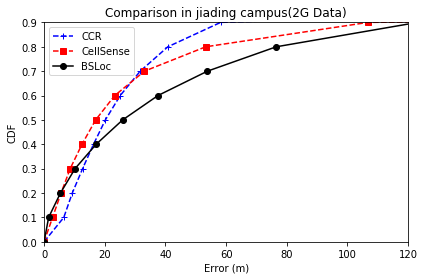

In [203]:
plot('jiading', '2g', xlim=(0,120), ylim=(0,0.90), title='Comparison in jiading campus(2G Data)', n_count=10)

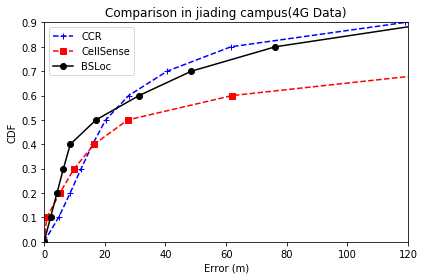

In [204]:
plot('jiading', '4g', xlim=(0,120), ylim=(0,0.90), title='Comparison in jiading campus(4G Data)', n_count=10)

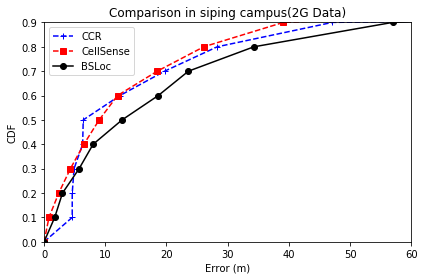

In [184]:
plot('siping', '2g', xlim=(0,60), ylim=(0,0.90), title='Comparison in siping campus(2G Data)', n_count=10)

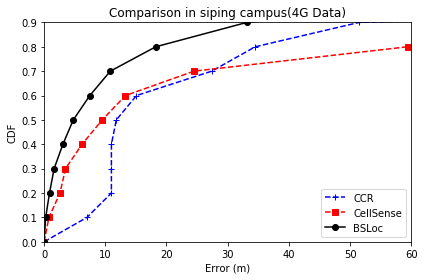

In [185]:
plot('siping', '4g', xlim=(0,60), ylim=(0,0.90), title='Comparison in siping campus(4G Data)', n_count=10)